In [1]:
from rl.distribution import Distribution, Constant, Gaussian, Choose, SampledDistribution
from itertools import product
from collections import defaultdict
import operator
from typing import Mapping, Iterator, TypeVar, Tuple, Dict, Iterable, Generic

import numpy as np

from rl.distribution import Categorical, Choose
from rl.markov_process import NonTerminal, State, Terminal
from rl.markov_decision_process import (MarkovDecisionProcess, FiniteMarkovDecisionProcess, FiniteMarkovRewardProcess)
from rl.policy import FinitePolicy, FiniteDeterministicPolicy
from rl.approximate_dynamic_programming import ValueFunctionApprox, \
    QValueFunctionApprox, NTStateDistribution, extended_vf

import random 

from dataclasses import dataclass
from rl import dynamic_programming

from rl.approximate_dynamic_programming import QValueFunctionApprox
from rl.td import PolicyFromQType, epsilon_greedy_action


S = TypeVar('S')
A = TypeVar('A')

In [2]:
class TabularQValueFunctionApprox(Generic[S, A]):
    '''
    A basic implementation of a tabular function approximation with constant learning rate of 0.1
    also tracks the number of updates per state
    You should use this class in your implementation
    '''
    
    def __init__(self):
        self.counts: Mapping[Tuple[NonTerminal[S], A], int] = defaultdict(int)
        self.values: Mapping[Tuple[NonTerminal[S], A], float] = defaultdict(float)
    
    def update(self, k: Tuple[NonTerminal[S], A], tgt):
        alpha = 0.1
        self.values[k] = (1 - alpha) * self.values[k] + tgt * alpha
        self.counts[k] += 1
    
    def __call__(self, x_value: Tuple[NonTerminal[S], A]) -> float:
        return self.values[x_value]

In [367]:
def double_q_learning(
    mdp: MarkovDecisionProcess[S, A],
    states: NTStateDistribution[S],
    γ: float
) -> Iterator[TabularQValueFunctionApprox[S, A]]:
    '''
    Implement the double q-learning algorithm as outlined in the question
    '''
    ##### Your Code HERE #########
    q_0_1 = TabularQValueFunctionApprox()
    q_0_2 = TabularQValueFunctionApprox()
    q_1: TabularQValueFunctionApprox[S, A] = q_0_1
    q_2: TabularQValueFunctionApprox[S, A] = q_0_2
    
    def q_estimate(q1: TabularQValueFunctionApprox[S, A], q2: TabularQValueFunctionApprox[S, A]):
        
        q_est = TabularQValueFunctionApprox()
        
        allSAPairs = set()
        for (s,a) in q1.counts.keys():
            allSAPairs.add((s,a))
        for (s,a) in q2.counts.keys():
            allSAPairs.add((s,a))
        
        for (s,a) in allSAPairs:
            q1Count = q1.counts[(s,a)]
            q2Count = q2.counts[(s,a)]
            q1Value = q1.values[(s,a)]
            q2Value = q2.values[(s,a)]
            totalCount = q1Count + q2Count
            q_est.values[(s,a)] = (q1Value * q1Count + q2Value * q2Count)/(q1Count + q2Count)
            q_est.counts[(s,a)] = totalCount
        
        return q_est
    
    q_est = q_estimate(q_1, q_2)
    
    yield q_est
    
    while True:
        
        startState: NonTerminal[S] = states.sample()
        T = 0
            
        currState = startState
        
        while isinstance(currState, NonTerminal):
            currAction = epsilon_greedy_action(q=q_estimate(q_1,q_2), nt_state=currState,
            actions=set(mdp.actions(currState)), ϵ=0.1)
            
            nextState, reward = mdp.step(currState, currAction).sample()
            
            updateQ = random.randint(1,2)
            
            if updateQ == 1:
                if isinstance(nextState, Terminal):
                    target = reward
                else:
                    maxAction = epsilon_greedy_action(q=q_2, nt_state=nextState,
                    actions=set(mdp.actions(nextState)), ϵ=0)

                    maxASValue = q_1((nextState, maxAction))
                    target = reward + γ * maxASValue
                
                q_1.update((currState, currAction), target)
                
            else:
                if isinstance(nextState, Terminal):
                    target = reward
                else:
                    maxAction = epsilon_greedy_action(q=q_1, nt_state=nextState,
                    actions=set(mdp.actions(nextState)), ϵ=0)

                    maxASValue = q_2((nextState, maxAction))
                    target = reward + γ * maxASValue

                q_2.update((currState, currAction), target)
            
            T += 1
            currState = nextState
        
        q_est = q_estimate(q_1, q_2)
        yield q_est
    
    ##### End Your Code HERE #########


In [368]:
def q_learning(
    mdp: MarkovDecisionProcess[S, A],
    states: NTStateDistribution[S],
    γ: float
) -> Iterator[TabularQValueFunctionApprox[S, A]]:
    '''
    Implement the standard q-learning algorithm as outlined in the question
    '''
    ##### Your Code HERE #########
    q_0 = TabularQValueFunctionApprox()
    q: TabularQValueFunctionApprox[S, A] = q_0
        
    yield q
    while True:
        
        startState: NonTerminal[S] = states.sample()
        T = 0
            
        currState = startState
        
        while isinstance(currState, NonTerminal):
            currAction = epsilon_greedy_action(q=q, nt_state=currState,
            actions=set(mdp.actions(currState)), ϵ=0.1)
            
            transitionStep = mdp.step(currState, currAction).sample()
            nextState = transitionStep[0]
            reward = transitionStep[1]

            
            if isinstance(nextState, Terminal):
                target = reward
            else:
                maxAction = epsilon_greedy_action(q=q, nt_state=nextState,
                actions=set(mdp.actions(nextState)), ϵ=0)

                maxASValue = q((nextState, maxAction))
                target = reward + γ * maxASValue
            
            q.update((currState, currAction), target)
            
            T += 1
            
            currState = nextState

        yield q
        
    #pass
    ##### End Your Code HERE #########

In [372]:
@dataclass(frozen=True)
class P1State:
    '''
    Add any data and functionality you need from your state
    '''
    ##### Your Code HERE #########
    char: S
    ##### End Your Code HERE #########
    

class P1MDP(MarkovDecisionProcess[P1State, str]):
    
    def __init__(self, n):
        self.n = n
        
        
    def actions(self, state: NonTerminal[P1State]) -> Iterable[str]:
        '''
        return the actions available from: state
        '''
        ##### Your Code HERE #########
        if state.state.char == 'A':
            return ["a1", "a2"]
        elif state.state.char == 'B':
            return ["b" + str(i) for i in range(1,self.n + 1)]
        #pass
        ##### End Your Code HERE #########
    
    def step(
        self,
        state: NonTerminal[P1State],
        action: str
    ) -> Distribution[Tuple[State[P1State], float]]:
        '''
        return the distribution of next states conditioned on: (state, action)
        '''
        ##### Your Code HERE #########
        
        if state.state.char == 'A':
            if action == "a1":
                return Categorical({(NonTerminal(P1State('B')), 0) : 1})
            elif action == "a2":
                return Categorical({(Terminal(P1State('T')), 0) : 1})
        
        if state.state.char == 'B':
            def nextStateReward():
                currReward = np.random.normal(loc = -0.1, scale=1)
                nextState = Terminal(P1State('T'))
                return (nextState, currReward)

            return SampledDistribution(nextStateReward)
        #pass
        ##### End Your Code HERE #########

In [373]:
useMdp = P1MDP(n = 10)

startDist = Categorical({NonTerminal(P1State('A')): 1})

runs = 100
episodes = 400

Q_std_all = [0 for i in range(0,episodes+1)]

for i in range(runs):
    num_episode = 0
    for q in q_learning(useMdp, startDist, 1):
        if (num_episode > episodes):
            break

        
        val = q((NonTerminal(P1State('A')), "a1"))
        #print(val)

        Q_std_all[num_episode] += val

        num_episode += 1

np_Q_std = np.array(Q_std_all)
np_Q_std /= runs


Q_dbl_all = [0 for i in range(0,episodes+1)]

for i in range(runs):
    num_episode = 0
    for q_dbl in double_q_learning(useMdp, startDist, 1):
        if (num_episode > episodes):
            break

        val = q_dbl((NonTerminal(P1State('A')), "a1"))

        Q_dbl_all[num_episode] += val

        num_episode += 1

np_Q_dbl = np.array(Q_dbl_all)
np_Q_dbl /= runs

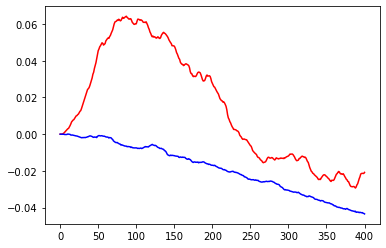

In [374]:
import matplotlib         
from matplotlib import pyplot as plt

graphArrX = np.arange(episodes + 1)
plt.plot(graphArrX, np_Q_std, color = "red")
plt.plot(graphArrX, np_Q_dbl, color = "blue")
plt.show()